# Collect data

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import os

# --- 설정값 ---
TOTAL_STEPS = 20000
ENV_ID = 'LunarLander-v3'

print(f"'{ENV_ID}' 환경에서 총 {TOTAL_STEPS} 스텝의 데이터를 수집합니다.")

# --- 환경 초기화 ---
env = gym.make(ENV_ID, render_mode='rgb_array')

# --- 데이터 버퍼 ---
obs_buffer = []
frame_buffer = []
action_buffer = []
reward_buffer = []
terminated_buffer = []
truncated_buffer = []

observation, info = env.reset()

for _ in tqdm(range(TOTAL_STEPS)):
    action = env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env.step(action)
    
    # 버퍼에 저장
    obs_buffer.append(observation)  # 상태 (벡터)
    frame = env.render()            # 프레임 이미지
    frame_buffer.append(frame)     # 이미지 추가

    action_buffer.append(action)
    reward_buffer.append(reward)
    terminated_buffer.append(terminated)
    truncated_buffer.append(truncated)

    if terminated or truncated:
        observation, info = env.reset()
    else:
        observation = next_observation

env.close()

print(f"\n데이터 수집 완료! 총 {len(obs_buffer)}개의 경험을 저장했습니다.")

# --- 저장 디렉토리 만들기 ---
os.makedirs("data", exist_ok=True)

# --- 저장 ---
np.savez_compressed(
    f"data/{ENV_ID}_with_frames_1.npz",
    observations=np.array(obs_buffer, dtype=np.float32),  # (100000, 8)
    frames=np.array(frame_buffer, dtype=np.uint8),        # (100000, H, W, 3)
    actions=np.array(action_buffer, dtype=np.int8),
    rewards=np.array(reward_buffer, dtype=np.float32),
    terminateds=np.array(terminated_buffer, dtype=np.bool_),
    truncateds=np.array(truncated_buffer, dtype=np.bool_)
)

print(f"✅ '{ENV_ID}_with_frames_1.npz' 파일로 프레임 포함 데이터 저장 완료!")

In [2]:
import numpy as np
data = np.load('data/LunarLander-v3.npz')
observations_raw = data['frames']
actions = data['actions']
rewards = data['rewards']

# VAE train

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
from torchvision import transforms
from parts.VAE_CNN import VAE, vae_loss_function, CustomImageDataset
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss
from parts.controller import controller
from tqdm.notebook import tqdm

observations = torch.tensor(observations_raw).permute(0, 3, 1, 2)
vae = VAE(input_channel=3, latent_dim=1024).to('cuda:0')

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 

observations = CustomImageDataset(data=observations, transform=resize)

dataloader = DataLoader(dataset=observations, batch_size=512)

optimizer = optim.AdamW(vae.parameters(), lr=1e-4)

def vae_train(vae, optimizer, dataloader, epochs=10):
    vae.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, data in enumerate(tqdm(dataloader)):
            data = data.to('cuda:0')
            _, recon_image, mu, logvar = vae(data)

            loss = vae_loss_function(recon_image, data, mu, logvar, beta=0.01)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
        
        print(f'Epoch {epoch}, Everage loss: {total_loss/len(dataloader):.6f}')

vae_train(vae, optimizer, dataloader, epochs=100)


In [4]:
torch.save(vae.state_dict(), 'vae-latent1024-epoch100.pth')

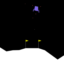

In [5]:
to_pil = transforms.ToPILImage()
to_pil(observations[555])

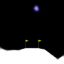

In [6]:
vae.eval()
data = observations[555].unsqueeze(0).to("cuda:0")
hidden_state, recon_image, _, _ = vae(data)
to_pil(recon_image[0])

# MDN_RNN train

In [1]:
import numpy as np
data = np.load('data/LunarLander-v3.npz')
observations_raw = data['frames']
actions = data['actions']
rewards = data['rewards']

episodes = [0]
for idx, done in enumerate(data['terminateds']):
    if done == True:
        episodes.append(idx+1)
episodes.append(len(data['terminateds']))


In [2]:
from torchvision import transforms
import torch

# observations = torch.tensor(observations_raw).permute(0, 3, 1, 2)
observations = observations_raw # numpy array dimension order is [H, W, C] for ToPILImage()

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 

import torch
from parts.VAE_CNN import VAE
vae = VAE(input_channel=3, latent_dim=1024).to('cuda:0')
vae.load_state_dict(torch.load('model_weights/vae_weights_latent1024.pth'))
vae.eval()

VAE(
  (encode_cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): SiLU()
  )
  (mu_linear): Linear(in_features=4096, out_features=1024, bias=True)
  (var_linear): Linear(in_features=4096, out_features=1024, bias=True)
  (decode_linear): Linear(in_features=1024, out_features=4096, bias=True)
  (decode_cnn): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SiLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4),

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import optim
from PIL import Image
from tqdm.notebook import tqdm
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss, SequenceDataset
import numpy as np

action_size = int(actions.max()) + 1
action_onehot = np.eye(action_size)[actions] # np.eye is generates identity matrix

mdn_rnn = MDN_RNN(input_size=1024, hidden_size=512, latent_space_size=1024, action_size=action_size).to('cuda:0')

seq_dataset = SequenceDataset(image_dataset=observations, transforms=resize, reward_dataset=rewards, action_dataset=action_onehot, episodes=episodes)
dataloader = DataLoader(dataset=seq_dataset, batch_size=32, num_workers=12)

optimizer = optim.AdamW(mdn_rnn.parameters(), lr=1e-4)

def rnn_train(model=mdn_rnn, dataloader=dataloader, optimizer=optimizer, epochs=400):
    model.train()
    vae.eval()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (image, action, reward, seq_length, mask, t_done) in enumerate(tqdm(dataloader, desc=f'epoch: {epoch+1}')):
            image, action, reward, mask, t_done = image.to('cuda:0'), action.to('cuda:0'), reward.to('cuda:0'), mask.to('cuda:0'), t_done.to('cuda:0')
            with torch.no_grad():
                # have to reshape image vector because vae(cnn) input shape is (batch_size, channel_size, height, width)
                batch, sequence, C, H, W = image.size()
                reshape_images = image.view(-1, C, H, W)
                z_vectors_flatten, _, _, _ = vae(reshape_images)
                z_vectors = z_vectors_flatten.view(batch, sequence, -1)
                
            mu, sigma, phi, p_reward, p_done, _, (_, _) = model(z_vectors, action, length=seq_length)
            
            batch, sequence, num_dist, latent_size = mu.size()

            mu_pred = mu[: , :-1, :, :].reshape(-1, num_dist, latent_size)
            sigma_pred = sigma[: , :-1, :, :].reshape(-1, num_dist, latent_size)
            phi_pred = phi[: , :-1, :].reshape(-1, num_dist)
            p_reward_pred = p_reward[:, :-1].reshape(-1, 1)

            target_z = z_vectors[: , 1:, :].reshape(-1, latent_size)
            target_reward = reward[:, 1:].reshape(-1, 1)

            reshape_mask = mask[:, :].reshape(-1, 1)
            
            loss = mdn_rnn_loss(mu_pred, sigma_pred, phi_pred, target_z, p_reward_pred, target_reward, p_done, t_done, reshape_mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if (batch_idx + 1) % 100 == 0:
                print(f"loss {total_loss / (batch_idx + 1)}")

        print(f"epoch: {epoch+1}, Everage loss: {total_loss/len(dataloader):.6f}")

rnn_train()

In [ ]:
torch.save(mdn_rnn.state_dict(), 'model_weights/mdnrnn_weights_latent1024.pth')

# RNN test

In [1]:
import numpy as np
data = np.load('data/LunarLander-v3.npz')
observations_raw = data['frames']
actions = data['actions']
rewards = data['rewards']

episodes = [0]
for idx, done in enumerate(data['terminateds']):
    if done == True:
        episodes.append(idx+1)
episodes.append(len(data['terminateds']))

In [2]:
import torch
from parts.VAE_CNN import VAE, vae_loss_function, CustomImageDataset
from parts.MDN_RNN import MDN_RNN, mdn_rnn_loss, sampling, SequenceDataset
from parts.controller import controller

action_size = int(actions.max()) + 1
action_onehot = np.eye(action_size)[actions] # np.eye is generates identity matrix

vae = VAE(input_channel=3, latent_dim=1024).to('cuda:0')
mdn_rnn = MDN_RNN(input_size=1024, hidden_size=512, latent_space_size=1024, action_size=action_size).to('cuda:0')

vae.load_state_dict(torch.load('model_weights/vae_weights_latent1024.pth'))
mdn_rnn.load_state_dict(torch.load('model_weights/mdnrnn_weights_latent1024.pth'))


<All keys matched successfully>

In [3]:
from torchvision import transforms

observations = observations_raw

resize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()]) 


seq_dataset = SequenceDataset(image_dataset=observations, transforms=resize, reward_dataset=rewards, action_dataset=action_onehot, episodes=episodes)

In [4]:
vae.eval()
mdn_rnn.eval()
z_vectors, _, _, _  = vae(seq_dataset[100][0].to('cuda:0'))
z_vectors = z_vectors.unsqueeze(0)
action_first = seq_dataset[100][1].to('cuda:0')
action_first = action_first.unsqueeze(0)

mu, sigma, phi, reward, h, cell = mdn_rnn(z_vectors, action_first)

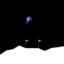

In [5]:
to_pil = transforms.ToPILImage()
to_pil(seq_dataset[100][0][88])

In [27]:
p = phi[:, 120, :]
m = mu[:, 120, :, :]
s = sigma[:, 120, :, :]

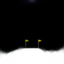

In [45]:
from torch import distributions
from torchvision import transforms

mixture_distribution = distributions.Categorical(probs=p)
component_distribution = distributions.Normal(loc=m, scale=s)
component_dist = distributions.Independent(
    component_distribution,
    reinterpreted_batch_ndims=1
)
mixture_gaussian = distributions.MixtureSameFamily(mixture_distribution, component_dist)
vector = mixture_gaussian.sample()

to_pil = transforms.ToPILImage()
a = vae.decode(vector)
img = to_pil(a[0])
img

# Controller train

In [1]:
import numpy as np
from parts.MDN_RNN import MDN_RNN, sampling
from parts.controller import controller, choice_control
from parts.VAE_CNN import VAE
import torch

data = np.load('data/LunarLander-v3.npz')

actions = data['actions']
action_size = int(actions.max()) + 1

images = data['frames']

mdn_rnn = MDN_RNN(input_size=1024, hidden_size=512, latent_space_size=1024, action_size=action_size).to('cuda:0')
mdn_rnn.load_state_dict(torch.load('model_weights/mdnrnn_weights_latent1024.pth'))

vae = VAE(input_channel=3, latent_dim=1024).to('cuda:0')
vae.load_state_dict(torch.load('model_weights/vae_weights_latent1024.pth'))
vae.eval()

VAE(
  (encode_cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): SiLU()
  )
  (mu_linear): Linear(in_features=4096, out_features=1024, bias=True)
  (var_linear): Linear(in_features=4096, out_features=1024, bias=True)
  (decode_linear): Linear(in_features=1024, out_features=4096, bias=True)
  (decode_cnn): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): SiLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): SiLU()
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4),

In [2]:
import torch 
from torchvision import transforms
import random

resize = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor()])

def sellect_random_scene(images) :
    _len = len(images)
    scene_number = random.randint(0, _len-1)
    image = images[scene_number]
    
    image_tensor = torch.tensor(image).permute(2, 0, 1)

    resized_image = torch.tensor(resize(image_tensor)).unsqueeze(0).to('cuda:0')

    with torch.no_grad():
        z_vector, _ ,_ ,_ = vae(resized_image)

    num_layers, hidden_size = mdn_rnn.lstm.num_layers, mdn_rnn.lstm.hidden_size

    h_vector = torch.zeros(1, hidden_size).to('cuda:0')

    h_n, c_n = torch.zeros(num_layers, 1, hidden_size).to('cuda:0'), torch.zeros(num_layers, 1, hidden_size).to('cuda:0')

    return z_vector, h_vector, (h_n, c_n)


In [ ]:
from parts.MDN_RNN import MDN_RNN, sampling
from parts.controller import controller, choice_control
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

C = controller(action_size=action_size, h_vector_size=512, z_vector_size=1024, hidden_size=512).to('cuda:0')

optimizer = torch.optim.AdamW(C.parameters(), lr=1e-4)

gamma = 0.99
beta = 0.01 

def controller_train(steps, controller, optimizer, initial_z, initial_h, cell):
    controller.train()
    mdn_rnn.train()

    rewards = []
    action_probs = []
    entropies = []

    z = initial_z.to('cuda:0')
    h = initial_h.to('cuda:0')

    z_rnn = z.unsqueeze(0)

    for _ in range(steps):
        action_prob = controller(z, h)
        action = choice_control(action_prob)

        action_onehot_tensor = F.one_hot(action, num_classes=action_size).to(torch.float32)

        mu, sigma, phi, reward, h, cell = mdn_rnn(z_rnn, action_onehot_tensor, cell)

        z_rnn = sampling(mu, sigma, phi) 
        z = z_rnn.squeeze(0)

        log_action_prob = torch.log(action_prob[0, action])

        entropy = action_prob[0] * torch.log(action_prob[0])

        # print(z)
        # to_pil = transforms.ToPILImage()
        # a = vae.decode(z)
        # img = to_pil(a[0])
        # plt.figure(figsize=(5, 5))
        # plt.imshow(img)
        # plt.axis('off')
        # plt.show()
        
        
        entropies.append(-entropy.sum())
        action_probs.append(log_action_prob)
        rewards.append(reward)
        
    # total_imagined_reward = torch.stack(rewards)
    
    # total_action_prob = torch.stack(action_probs)
    # total_entoprys = torch.stack(entropys).sum()

    # loss_element_wise = total_action_prob * total_imagined_reward.detach() # reinforce algorithm
    # loss = -loss_element_wise.sum() - total_entoprys*0.1

    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    # return loss.item(), total_imagined_reward.sum(), total_action_prob.sum()
    returns = []
    future_return = 0.0
    for r in reversed(rewards):
        future_return = r + gamma * future_return
        returns.append(future_return)
    returns.reverse()
    returns = torch.stack(returns)
    
    # 보상 정규화 (학습 안정화)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    action_probs = torch.stack(action_probs)
    entropies = torch.stack(entropies)

    # <--- 엔트로피 보너스 구현 Step 2: 최종 손실 함수에 반영
    policy_loss = - (action_probs * returns.detach()).mean() # 정책 손실
    entropy_loss = - (beta * entropies.mean()) # 엔트로피 손실 (엔트로피를 최대화하기 위해 음수로 만듦)

    loss = policy_loss + entropy_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss.item()과 함께 실제 보상 합계, 정책 손실, 엔트로피 손실 등을 리턴하면 모니터링에 용이
    return loss.item(), torch.stack(rewards).sum().item()

In [ ]:
from tqdm.auto import tqdm

for _ in tqdm(range(1000)):
    initial_z, initial_h, (h_n, c_n) = sellect_random_scene(images)
    loss, reward = controller_train(50, C, optimizer, initial_z, initial_h, (h_n, c_n))
    print(f"loss:{loss}, reward:{reward}")

In [11]:
torch.save(C.state_dict(), 'controller-1')